In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# import sys
# !{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.svm import SVR

In [2]:
stocks = pd.read_csv("./data/EA_stocks_Mar_Jun_2016.csv")
twitter = pd.read_csv("./data/tweets_sentiment.csv")

stocks["Date"] = pd.to_datetime(stocks["Date"], format="%Y-%m-%d")
twitter["Date"] = pd.to_datetime(twitter["Date"], format="%Y-%m-%d")

In [3]:
twitter.tail()

,Date,Hour,cleaned_tweets,RTs,Followers,Tweet language (ISO 639-1),Compound,Positive,Negative,Neutral
4990,2016-03-28,00:26,$EA there's a reason it's stalling right here....,NaN,1755.0,en,-0.0772,0.197,0.292,0.511
4991,2016-03-27,22:38,Ave. $ea$on prod ICDMAW,4.0,489.0,es,0.0000,0.000,0.000,1.000
4992,2016-03-27,22:33,Ave. $ea$on prod ICDMAW,4.0,1024.0,es,0.0000,0.000,0.000,1.000
4993,2016-03-27,22:26,$EA:US Oculus' Virtual Reality Headset To Laun...,NaN,2746.0,en,0.0000,0.000,0.000,1.000
4994,2016-03-27,22:05,$EA: Electronic Arts (EA) Short Interest Discl...,NaN,737.0,en,0.4588,0.333,0.000,0.667


In [4]:
sentiment = []
for score in twitter["Compound"]:
    if score >= 0.05:
        sentiment.append("Positive")
    elif score <= -0.05:
        sentiment.append("Negative")
    else:
        sentiment.append("Neutral")

twitter["Sentiment"] = sentiment

In [5]:
daily_pos = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Positive"]["Date"].count()))
daily_neg = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Negative"]["Date"].count()))
daily_neu = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Neutral"]["Date"].count()))
volume_per_day = pd.DataFrame(twitter.groupby("Date")["Sentiment"].count())

twitter_copy = twitter.copy()
twitter_copy = twitter_copy.groupby("Date").mean()

twitter_copy["daily_pos"], twitter_copy["daily_neg"], \
    twitter_copy["daily_neu"], twitter_copy["Tweet Volume"] = daily_pos, daily_neg, \
                                                              daily_neu, volume_per_day

twitter_copy["Percent Positive"] = twitter_copy["daily_pos"] / twitter_copy["Tweet Volume"]
twitter_copy["Percent Negative"] = twitter_copy["daily_neg"] / twitter_copy["Tweet Volume"]
twitter_copy["Percent Neutral"] = twitter_copy["daily_neu"] / twitter_copy["Tweet Volume"]

twitter_copy.head()                                

,RTs,Followers,Compound,Positive,Negative,Neutral,daily_pos,daily_neg,daily_neu,Tweet Volume,Percent Positive,Percent Negative,Percent Neutral
Date,,,,,,,,,,,,,
2016-03-27,4.000000,1249.000000,0.114700,0.083250,0.000000,0.916750,1,0,3,4,0.250000,0.000000,0.750000
2016-03-28,4.235294,3731.804878,0.032063,0.044293,0.038561,0.917146,8,5,28,41,0.195122,0.121951,0.682927
2016-03-29,4.375000,4476.458333,0.089969,0.069500,0.038333,0.892167,25,8,39,72,0.347222,0.111111,0.541667
2016-03-30,1.000000,1897.916667,0.157995,0.080150,0.013900,0.905950,29,3,28,60,0.483333,0.050000,0.466667
2016-03-31,7.125000,4840.074074,0.082563,0.045741,0.004259,0.950000,6,1,20,27,0.222222,0.037037,0.740741


In [6]:
stocks["high_low_pct"] = (stocks["High"] - stocks["Low"]) / stocks["Low"]
stocks["close_open_pct"] = (stocks["Close"] - stocks["Open"]) / stocks["Open"]

stocks = stocks.set_index("Date")

In [7]:
stock_sentiment = twitter_copy.merge(stocks, left_index=True, right_index=True)
stock_sentiment.tail()

,RTs,Followers,Compound,Positive,Negative,Neutral,daily_pos,daily_neg,daily_neu,Tweet Volume,...,Percent Negative,Percent Neutral,Open,High,Low,Close,Adj Close,Volume,high_low_pct,close_open_pct
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-09,1.888889,5318.146341,0.059932,0.043488,0.015659,0.940829,8,3,30,41,...,0.073171,0.731707,75.589996,76.790001,75.519997,76.250000,75.456291,3055400,0.016817,0.008731
2016-06-10,1.500000,3168.190476,0.113702,0.068810,0.018452,0.912738,15,3,24,42,...,0.071429,0.571429,75.410004,76.239998,74.809998,75.279999,74.496376,3025100,0.019115,-0.001724
2016-06-13,1.914286,6279.806122,0.001591,0.045867,0.041071,0.913061,19,16,63,98,...,0.163265,0.642857,74.889999,75.430000,73.800003,74.239998,73.467216,3680300,0.022087,-0.008679
2016-06-14,2.428571,12440.492754,0.106746,0.078188,0.035435,0.886333,22,8,39,69,...,0.115942,0.565217,74.139999,74.779999,73.349998,74.519997,73.744293,2017000,0.019496,0.005125
2016-06-15,1.272727,2445.000000,0.173539,0.102697,0.003485,0.893818,12,0,21,33,...,0.000000,0.636364,74.559998,75.230003,74.040001,74.389999,73.615654,2409900,0.016072,-0.002280


### XGBoost Regressor

<AxesSubplot:xlabel='Date'>

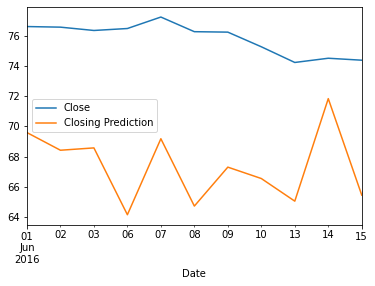

In [9]:
split = math.ceil(len(stock_sentiment) * 0.8)

train = stock_sentiment[:split]
test = stock_sentiment[split:]

predictors = ["Percent Positive", "Percent Negative", "Percent Neutral", "Volume", "high_low_pct", "close_open_pct"]

scaler = MinMaxScaler()
scaler.fit(train[predictors])
X_train_scaled = scaler.transform(train[predictors])
X_test_scaled = scaler.transform(test[predictors])

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train_scaled, train["Close"].values)
closing_pred = xgb_model.predict(X_test_scaled)

closing_pred = pd.Series(closing_pred, index=test.index, name="Closing Prediction")
comparison = pd.concat([test["Close"], closing_pred], axis=1)

comparison.plot()

In [12]:
def regression_metrics(y_true, yhat):
    '''return R^2, MSE, MAE, and RMSE metrics'''

    print(f'R^2: {metrics.r2_score(y_true, yhat)}')
    print(f'Mean Squared Error: {metrics.mean_squared_error(y_true, yhat)}')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_true, yhat)}')
    print(f'Root MSE: {metrics.mean_squared_error(y_true, yhat, squared=False)}')
    print(f'% MAE: {metrics.mean_absolute_percentage_error(y_true, yhat)}')

regression_metrics(test["Close"], closing_pred)

R^2: -77.32223194856397
Mean Squared Error: 77.73258794498359
Mean Absolute Error: 8.49143024493963
Root MSE: 8.816608641931635
% MAE: 0.11186264816062534


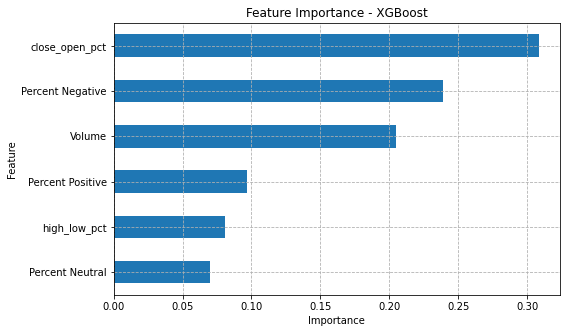

In [16]:
xgb_importance = xgb_model.feature_importances_

xgb_importance = pd.Series(xgb_importance, index=predictors).sort_values(ascending=True)

xgb_importance.plot(kind='barh',
                    figsize=(8,5),
                    title="Feature Importance - XGBoost",
                    xlabel="Feature")

plt.xlabel("Importance")
plt.grid(which="both", linestyle="--")
plt.show()

### SVR

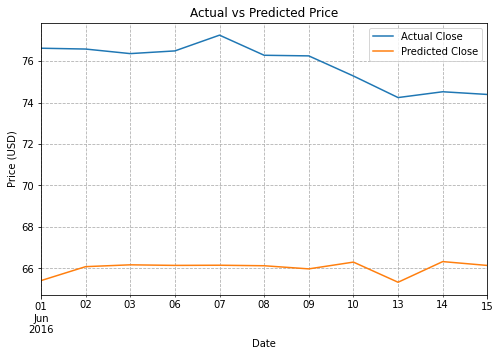

In [14]:
svr_model = SVR(kernel="rbf")
svr_model.fit(X_train_scaled, train["Close"].values)
closing_pred = svr_model.predict(X_test_scaled)

closing_pred = pd.Series(closing_pred, index=test.index, name="Predicted Close")

comparison = pd.concat([test["Close"], closing_pred], axis=1,)
comparison.rename({"Close": "Actual Close"}, axis=1, inplace=True)

comparison.plot(figsize=(8,5),
                title="Actual vs Predicted Price",
                ylabel="Price (USD)")
plt.grid(which="both", linestyle="--")
plt.show()

In [15]:
regression_metrics(test["Close"], closing_pred)

R^2: -97.31287011897761
Mean Squared Error: 97.57272785160067
Mean Absolute Error: 9.825239704930501
Root MSE: 9.877890860482347
% MAE: 0.12940291329811945


### LSTM

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense,LSTM

In [ ]:
# model = Sequential()

# model.add(LSTM(64, return_sequences=True, input_shape=(X_train_scaled.shape[1],1)))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(32))
# model.add(Dense(1))
# model.summary()

In [ ]:
# model.compile(optimizer="adam", loss="mean_squared_error")
# model.fit(X_train_scaled, train["Close"], batch_size=5, epochs=10)

In [ ]:
# predictions = model.predict(X_test_scaled)
# predictions

In [ ]:
# regression_metrics(test["Close"], predictions)